# Waste Products Classification Using Transfer Learning

Project for IBM AI Engineering certification course.

In [1]:
!pip install tensorflow numpy scikit-learn matplotlib -q

In [2]:
import os
import glob
import warnings
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn import metrics
import kagglehub

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')

In [3]:
tf.__version__

'2.19.0'

## Dataset

In [4]:
root_path = kagglehub.dataset_download("techsash/waste-classification-data")
print(root_path)

100%|██████████| 427M/427M [00:10<00:00, 41.4MB/s]

Extracting files...


/root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1


In [5]:
img_rows, img_cols = 150, 150
batch_size = 32
n_epochs = 10
n_classes = 2
val_split = 0.2
verbosity = 1
path = root_path + '/DATASET/TRAIN/'
path_test = root_path + '/DATASET/TEST/'
input_shape = (img_rows, img_cols, 3)
labels = ['O', 'R']
seed = 42

In [6]:
train_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
	  width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

In [7]:
train_generator = train_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size,
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'training'
)

val_generator = val_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size,
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'validation'
)

test_generator = test_datagen.flow_from_directory(
    directory=path_test,
    class_mode='binary',
    seed=seed,
    batch_size=batch_size,
    shuffle=False,
    target_size=(img_rows, img_cols)
)

Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


Labels: [np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O')]


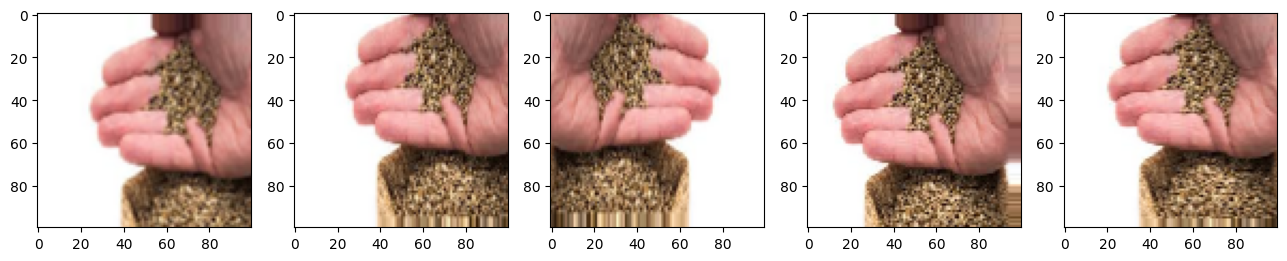

In [9]:
IMG_DIM = (100, 100)

train_files = glob.glob(path+'O/*')
train_files = train_files[:20]
train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [Path(fn).parent.name for fn in train_files]

img_id = 0
O_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
O = [next(O_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in O])
l = [ax[i].imshow(O[i][0][0]) for i in range(0,5)]


## Model

### Extract Features Model Training

In [10]:
input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [11]:
output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

for layer in basemodel.layers:
    layer.trainable = False

In [12]:
input_shape = basemodel.output_shape[1]

model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ (None, 8192)           │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,172,673 (73.14 MB)

 Trainable params: 4,457,985 (17.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

for layer in basemodel.layers:
    layer.trainable = False

In [14]:
checkpoint_path='O_R_tlearn_vgg16.keras'

class LossHistory_(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(epoch))
        print('lr:', exp_decay(len(self.losses)))

def exp_decay(epoch):
    initial_lrate = 1e-4
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss',
                    patience = 4,
                    mode = 'min',
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

In [15]:
extract_feat_model = model.fit(train_generator,
                               steps_per_epoch=5,
                               epochs=10,
                               callbacks = callbacks_list_,
                               validation_data=val_generator,
                               validation_steps=val_generator.samples // batch_size,
                               verbose=1)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.5150 - loss: 0.7999lr: 9.048374180359596e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.5250 - loss: 0.7867 - val_accuracy: 0.5625 - val_loss: 0.6463 - learning_rate: 1.0000e-04
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.5471 - loss: 0.6699lr: 8.187307530779819e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.5611 - loss: 0.6622 - val_accuracy: 0.8205 - val_loss: 0.5034 - learning_rate: 9.0484e-05
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.6649 - loss: 0.6118lr: 7.408182206817179e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.6676 - loss: 0.6096 - val_accuracy: 0.8293 - val_loss: 0.4564 - learning_rate: 8.1873e-05
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7504 - loss: 0.4853lr: 6.703200460356394e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.7524 - loss: 0.4835 - val_accuracy: 0.8338 - val_loss: 0.4334 - learning_rate: 7.4082e-05


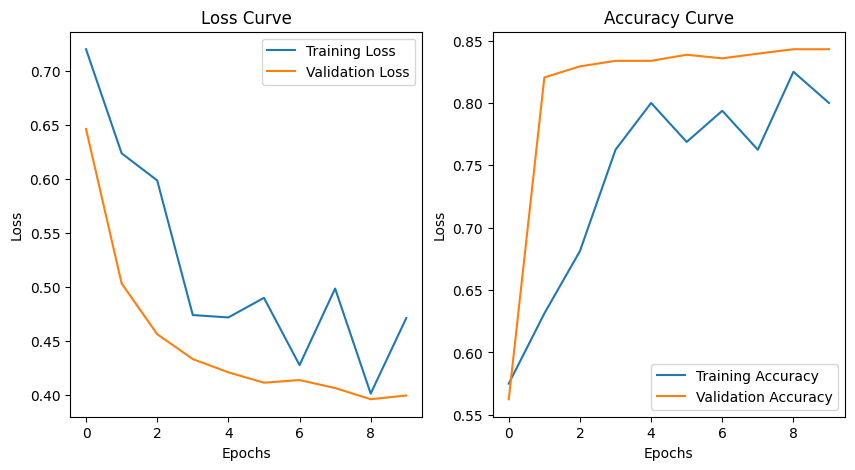

In [16]:
history = extract_feat_model

_, axes = plt.subplots(1,2,figsize=(10, 5))
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Loss Curve')

axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Accuracy Curve')

for ax in axes.flatten():
  ax.set_xlabel('Epochs')
  ax.set_ylabel('Loss')
  ax.legend()

plt.show()

### Fine-Tuned Model Training

In [17]:
input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)

output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

for layer in basemodel.layers:
    layer.trainable = False

display([layer.name for layer in basemodel.layers])

set_trainable = False

for layer in basemodel.layers:
    if layer.name in ['block5_conv3']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in basemodel.layers:
    print(f"{layer.name}: {layer.trainable}")

['input_layer_2',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool',
 'flatten_1']

input_layer_2: False
block1_conv1: False
block1_conv2: False
block1_pool: False
block2_conv1: False
block2_conv2: False
block2_pool: False
block3_conv1: False
block3_conv2: False
block3_conv3: False
block3_pool: False
block4_conv1: False
block4_conv2: False
block4_conv3: False
block4_pool: False
block5_conv1: False
block5_conv2: False
block5_conv3: True
block5_pool: True
flatten_1: True


In [18]:
model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

checkpoint_path='O_R_tlearn_fine_tune_vgg16.keras'

loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss',
                    patience = 4,
                    mode = 'min',
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

fine_tune_model = model.fit(train_generator,
                    steps_per_epoch=5,
                    epochs=10,
                    callbacks = callbacks_list_,
                    validation_data=val_generator,
                    validation_steps=val_generator.samples // batch_size,
                    verbose=1)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.5130 - loss: 0.8575lr: 9.048374180359596e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.5213 - loss: 0.8475 - val_accuracy: 0.8296 - val_loss: 0.4997 - learning_rate: 1.0000e-04
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.7779 - loss: 0.5562lr: 8.187307530779819e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.7722 - loss: 0.5609 - val_accuracy: 0.8500 - val_loss: 0.4359 - learning_rate: 9.0484e-05
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.7457 - loss: 0.4918lr: 7.408182206817179e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.7537 - loss: 0.4863 - val_accuracy: 0.8457 - val_loss: 0.4215 - learning_rate: 8.1873e-05
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8076 - loss: 0.4509lr: 6.703200460356394e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.8126 - loss: 0.4436 - val_accuracy: 0.8298 - val_loss: 0.4042 - learning_rate: 7.4082e-05


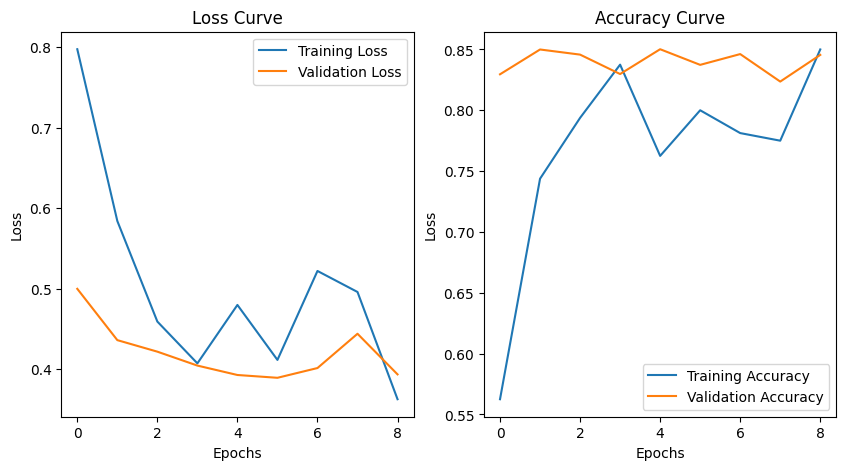

In [19]:
history = fine_tune_model

_, axes = plt.subplots(1,2,figsize=(10, 5))
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Loss Curve')

axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Accuracy Curve')

for ax in axes.flatten():
  ax.set_xlabel('Epochs')
  ax.set_ylabel('Loss')
  ax.legend()

plt.show()

### Evaluation

In [20]:
extract_feat_model = tf.keras.models.load_model('O_R_tlearn_vgg16.keras')
fine_tune_model = tf.keras.models.load_model('O_R_tlearn_fine_tune_vgg16.keras')

IMG_DIM = (150, 150)

test_files_O = glob.glob(path_test+'O/*')
test_files_R = glob.glob(path_test+'R/*')
test_files = test_files_O[:50] + test_files_R[:50]

test_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [Path(fn).parent.name for fn in test_files]

test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

class2num_lt = lambda l: [0 if x == 'O' else 1 for x in l]
num2class_lt = lambda l: ['O' if x < 0.5 else 'R' for x in l]

test_labels_enc = class2num_lt(test_labels)

predictions_extract_feat_model = extract_feat_model.predict(test_imgs_scaled, verbose=0)
predictions_fine_tune_model = fine_tune_model.predict(test_imgs_scaled, verbose=0)

predictions_extract_feat_model = num2class_lt(predictions_extract_feat_model)
predictions_fine_tune_model = num2class_lt(predictions_fine_tune_model)

print('Extract Features Model')
print(metrics.classification_report(test_labels, predictions_extract_feat_model))
print('Fine-Tuned Model')
print(metrics.classification_report(test_labels, predictions_fine_tune_model))

Extract Features Model
              precision    recall  f1-score   support

           O       0.80      0.90      0.85        50
           R       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

Fine-Tuned Model
              precision    recall  f1-score   support

           O       0.88      0.86      0.87        50
           R       0.86      0.88      0.87        50

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100



In [23]:
def plot_image_with_title(image, model_name, actual_label, predicted_label):
    plt.imshow(image)
    plt.title(f"Model: {model_name}, Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

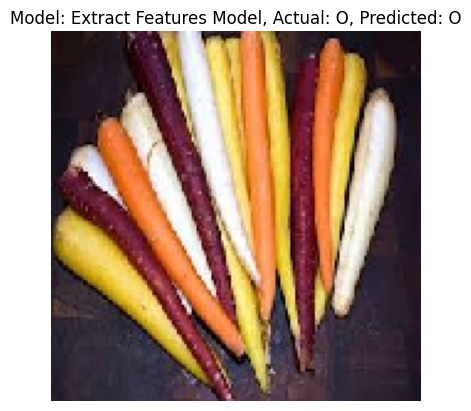

In [24]:
index_to_plot = 1
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Extract Features Model',
    actual_label=test_labels[index_to_plot],
    predicted_label=predictions_extract_feat_model[index_to_plot],
  )

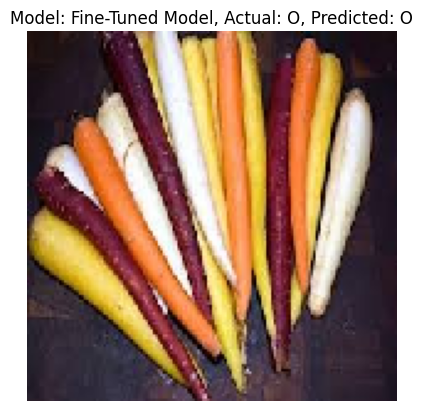

In [25]:
index_to_plot = 1
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Fine-Tuned Model',
    actual_label=test_labels[index_to_plot],
    predicted_label=predictions_fine_tune_model[index_to_plot],
)